# Reading in data

In [1]:
using Gurobi, StatsBase, CSV, DataFrames, JuMP, LinearAlgebra, Distributions, Random, GLMNet, Printf

In [2]:
data = CSV.read("final_df.csv", DataFrame);

In [3]:
first(data, 5)

Row,food,emissions,price,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,lucopene,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
,String31,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Wheat & Rye (Bread),0.0014,0.00145,100,2.67,0.032,0.008,0.0,5.08,0.187,0.85,0.2,0.0562,0.0,0.00253,0.00415,0.02,0.0,0.0,0.01,0.0,0.44,0.0,0.0,0.00111,0.002,0.0,0.0019,0.0019,0.049,1.33,0.00159,0.0349,0.45,0.01177,1.49,1.77,0.288,0.0119,0.1072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4868,0.04,0.0591,0.0245,0.0,0.0178,0.0,0.0168,0.0,0.0324,0.00777,0.00607,0.01499,0.0,0.0,0.0216,0.0,0.0,0.352
2,Maize (Meal),0.0011,0.00064,100,3.45,0.016,0.003,0.0,0.04,0.378,0.08,0.0,0.06269,0.00145,0.00114,0.0037,0.0,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.00396,0.0,0.0,0.0057,0.0057,0.022,0.32,0.00343,0.0268,0.96,0.01034,2.96,3.09,0.377,0.02,0.105,0.00409,0.00526,0.00655,0.00232,0.02741,0.0038,0.00236,0.0,0.00383,0.00713,0.00391,0.00202,0.00589,0.01247,0.00443,0.00356,0.00175,0.00301,0.00515,0.7452,0.101,0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.00335,0.00205,0.00771,0.0,0.0,0.0128,0.0,0.0,0.1211
3,Barley (Beer),0.0011,0.00148,100,0.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039,0.0011,0.0,0.0,0.9277
4,Oats,0.0016,0.00197,100,3.89,0.069,0.012,0.0,0.02,0.0,0.56,0.0,0.00961,0.01349,0.00139,0.00763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00119,0.0,0.0,0.0,0.0,0.0,0.54,0.00626,0.0472,1.77,0.04916,5.23,4.29,0.0,0.0397,0.1689,0.00881,0.01192,0.01448,0.00408,0.03712,0.00841,0.00405,0.0,0.00694,0.01284,0.00701,0.00312,0.00895,0.00934,0.0075,0.00575,0.00234,0.00573,0.00937,0.6627,0.106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069,0.01217,0.02178,0.02535,0.0,0.0,0.0172,0.0,0.0,0.0822
5,Rice,0.004,0.00134,100,3.57,0.011,0.002,0.0,0.07,0.35,0.95,0.0,0.06733,0.01074,0.00262,0.00115,0.19,0.01,0.0,0.11,0.0,2.2,0.0,0.0,0.00391,0.0,0.0,0.0082,0.0082,0.019,0.21,0.00524,0.0196,1.77,0.01329,4.33,4.27,0.028,0.0596,0.1473,0.00825,0.01136,0.01419,0.00174,0.02565,0.00672,0.00384,0.0,0.00618,0.01018,0.00629,0.00438,0.00721,0.00519,0.00778,0.00469,0.00179,0.00622,0.00858,0.749,0.062,0.025,0.0,0.0,0.0,0.0,0.0,0.0067,0.0108,0.00156,0.00159,0.00676,0.0,0.0,0.0153,0.0,0.0,0.0776


## Price data

In [4]:
price = data[!, "price"];

## Food data

In [5]:
food_products = data[!, "food"];

In [6]:
foods = size(food_products, 1);

### Emissions data

In [7]:
emissions = data[!, "emissions"];

### Nutritional data

In [8]:
calories = data[!, "calories"];

#### Macro nutrients

In [9]:
protein = data[!, "protein"]
total_fat = data[!, "total_fat"]
carbohydrate = data[!, "carbohydrate"]
fiber = data[!, "fiber"]
sugars = data[!, "sugars"]
saturated_fatty_acids = data[!, "saturated_fatty_acids"]
monounsaturated_fatty_acids = data[!, "monounsaturated_fatty_acids"]
polyunsaturated_fatty_acids = data[!, "polyunsaturated_fatty_acids"]
fatty_acids_total_trans = data[!, "fatty_acids_total_trans"];

#### Macro nutrients

In [10]:
vitamin_a = data[!, "vitamin_a"]
vitamin_b6 = data[!, "vitamin_b6"]
vitamin_b12 = data[!, "vitamin_b12"]
vitamin_c = data[!, "vitamin_c"]
vitamin_d = data[!, "vitamin_d"]
vitamin_e = data[!, "vitamin_e"]
vitamin_k = data[!, "vitamin_k"]
thiamin = data[!, "thiamin"]
riboflavin = data[!, "riboflavin"]
niacin = data[!, "niacin"]
folate = data[!, "folate"]
pantothenic_acid = data[!, "pantothenic_acid"]
calcium = data[!, "calcium"]
iron = data[!, "irom"]
magnesium = data[!, "magnesium"]
phosphorous = data[!, "phosphorous"]
potassium = data[!, "potassium"]
sodium = data[!, "sodium"]
zinc = data[!, "zink"]
copper = data[!, "copper"]
manganese = data[!, "manganese"]
selenium = data[!, "selenium"]
choline = data[!, "choline"]
lutein_zeaxanthin = data[!, "lutein_zeaxanthin"]
lucopene = data[!, "lucopene"]
carotene_beta = data[!, "carotene_beta"]
cryptoxanthin_beta = data[!, "cryptoxanthin_beta"]
tocopherol_alpha = data[!, "tocopherol_alpha"];

#### Amino Acids

In [11]:
alanine = data[!, "alanine"]
arginine = data[!, "arginine"]
aspartic_acid = data[!, "aspartic_acid"]
cystine = data[!, "cystine"]
glutamic_acid = data[!, "glutamic_acid"]
glycine = data[!, "glycine"]
histidine = data[!, "histidine"]
hydroxyproline = data[!, "hydroxyproline"]
isoleucine = data[!, "isoleucine"]
leucine = data[!, "leucine"]
lysine = data[!, "lysine"]
methionine = data[!, "methionine"]
phenylalanine = data[!, "phenylalanine"]
proline = data[!, "proline"]
serine = data[!, "serine"]
threonine = data[!, "threonine"]
tryptophan = data[!, "tryptophan"]
tyrosine = data[!, "tyrosine"]
valine = data[!, "valine"];

#### Other nutrients

In [12]:
water = data[!, "water"]
caffeine = data[!, "caffeine"]
theobromine = data[!, "theobromine"]
ash = data[!, "ash"]
alcohol = data[!, "alcohol"];

# Creating model

## Auxiliary variables

In [13]:
print(food_products)

String31["Wheat & Rye (Bread)", "Maize (Meal)", "Barley (Beer)", "Oats", "Rice", "Potatoes", "Cassava", "Cane Sugar", "Beet Sugar", "Beans", "Peas", "Nuts", "Peanuts", "Soymilk", "Tofu", "Soybean Oil", "Palm Oil", "Sunflower Oil", "Rapeseed Oil", "Olive Oil", "Tomatoes", "Onions & Leeks", "Turnips", "Cabbage", "Other Vegetables", "Mandarin Orange", "Bananas", "Apples", "Berries & Grapes", "Wine", "Melon", "Coffee", "Dark Chocolate", "Beef (beef herd)", "Beef (dairy herd)", "Lamb & Mutton", "Pork", "Chicken Meat", "Milk", "Cheese", "Eggs", "Fish (farmed)", "Shrimps (farmed)"]

In [14]:
# Define all food groups
fish = ["Fish (farmed)", "Shrimps (farmed)"]
fish_inds = [findfirst(isequal(item), food_products) for item in fish]

meats = ["Beef (beef herd)", "Beef (dairy herd)", "Lamb & Mutton", "Pork", "Chicken Meat"]
meat_inds = [findfirst(isequal(item), food_products) for item in meats]

animal = ["Beef (beef herd)", "Beef (dairy herd)", "Lamb & Mutton", "Pork", "Chicken Meat", "Milk", "Cheese", "Eggs", 
    "Fish (farmed)", "Shrimps (farmed)"]
animal_inds = [findfirst(isequal(item), food_products) for item in animal]

non_animal_inds = [index for (index, item) in enumerate(food_products) if !(item in animal)]

dairy = ["Milk", "Cheese"]
dairy_inds = [findfirst(isequal(item), food_products) for item in dairy]

gluten = ["Wheat & Rye (Bread)", "Barley (Beer)"]
gluten_inds = [findfirst(isequal(item), food_products) for item in gluten]

alcohol = ["Barley (Beer)", "Wine"];
alcohol_inds = [findfirst(isequal(item), food_products) for item in alcohol]

nuts = ["Nuts", "Peanuts"]
nuts_inds = [findfirst(isequal(item), food_products) for item in nuts]

caffeine = ["Coffee"]
caffeine_inds = [findfirst(isequal(item), food_products) for item in caffeine]

oil = ["Soybean Oil", "Palm Oil", "Sunflower Oil", "Rapeseed Oil", "Olive Oil"]
oil_inds = [findfirst(isequal(item), food_products) for item in oil]

sugar = ["Cane Sugar", "Beet Sugar"]
sugar_inds = [findfirst(isequal(item), food_products) for item in sugar];

In [15]:
# Big-M
M = 10000;

## Optimize diet function

In [16]:
function optimize_diet(lambda, min_calories, min_protein, min_carbs, min_fat, vegetarian, vegan, fish, 
        meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, 
        nuts_intolerant, alcohol, caffeine, carnivore, keto)
    
    # Price sensitivity
    lambda = lambda;

    # Dietary preferences
    z_veg = vegetarian
    z_vegan = vegan
    z_fish = fish
    z_meat_low = meat_low
    z_meat_med = meat_med
    z_meat_high = meat_high
    
    z_lactose = lactose_intolerant
    z_gluten = gluten_intolerant
    z_nuts = nuts_intolerant
    
    z_keto = keto
    z_carn = carnivore

    z_alc = alcohol
    z_caffeine = caffeine;

    # Create the model
    model = Model(Gurobi.Optimizer);

    # Define the decision variable
    @variable(model, x[1:foods] >= 0);

    # Define the dual objective function (to minimize total carbon emissions and cost)
    @objective(model, Min, sum(emissions[i] * x[i] for i in 1:foods) 
        + lambda * sum(price[i] * x[i] for i in 1:foods));

    # Ingredient limit constraints
    @constraint(model, ingredient_limit[i=1:foods], x[i] <= 500);
    @constraint(model, nuts_limit, x[findfirst(isequal("Nuts"), food_products)] <= 100)
    @constraint(model, peanuts_limit, x[findfirst(isequal("Peanuts"), food_products)] <= 100)
    @constraint(model, turnips_limit, x[findfirst(isequal("Turnips"), food_products)] <= 200)
    @constraint(model, cabbage_limit, x[findfirst(isequal("Cabbage"), food_products)] <= 200)
    @constraint(model, soymilk_limit, x[findfirst(isequal("Soymilk"), food_products)] <= 300)
    @constraint(model, mandarin_limit, x[findfirst(isequal("Mandarin Orange"), food_products)] <= 400)
    @constraint(model, oil_limit, sum(x[i] for i in oil_inds) <= 40)
    @constraint(model, sugar_limit, sum(x[i] for i in sugar_inds) <= 60)
    @constraint(model, potatoes_limit, x[findfirst(isequal("Potatoes"), food_products)] <= 300)
    @constraint(model, beans_limit, x[findfirst(isequal("Beans"), food_products)] <= 350)
    @constraint(model, peas_limit, x[findfirst(isequal("Peas"), food_products)] <= 250)
    @constraint(model, onions_limit, x[findfirst(isequal("Onions & Leeks"), food_products)] <= 200)
    @constraint(model, maize_limit, x[findfirst(isequal("Maize (Meal)"), food_products)] <= 250);

    # Dietary preference constraints
    @constraint(model, vegetarian_constraint[i in meat_inds], x[i] <= M * (1 - z_veg))
    @constraint(model, vegan_constraint[i in animal_inds], x[i] <= M * (1 - z_vegan))
    @constraint(model, lactose_constraint[i in dairy_inds], x[i] <= M * (1 - z_lactose))
    @constraint(model, gluten_constraint[i in gluten_inds], x[i] <= M * (1 - z_gluten))
    @constraint(model, nuts_constraint[i in nuts_inds], x[i] <= M * (1 - z_nuts))
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) <= M * (1 - z_keto) + 50) # Keto - allowing 50g of carbs
    @constraint(model, carnivore_constraint[i in non_animal_inds], x[i] <= M * (1 - z_carn) + 40) # Carnivore diet
    @constraint(model, carnivore_meat_constraint, sum(x[i] for i in meat_inds) >= 500 * z_carn)

    @constraint(model, alcohol_constraint, sum(x[i] for i in alcohol_inds) >= 50 * z_alc)
    @constraint(model, caffeine_constraint, sum(x[i] for i in caffeine_inds) >= 10 * z_caffeine)
    @constraint(model, fish_constraint, sum(x[i] for i in fish_inds) >= 100 * z_fish)
    @constraint(model, meat_low_constraint, sum(x[i] for i in meat_inds) >= 100 * z_meat_low)
    @constraint(model, meat_med_constraint, sum(x[i] for i in meat_inds) >= 200 * z_meat_med)
    @constraint(model, meat_high_constraint, sum(x[i] for i in meat_inds) >= 300 * z_meat_high);

    # Macro nutrient constraints
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= 50)         # Protein minimum 50g
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= min_protein)
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= 78)       # Fat minimum 78g
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= min_fat)
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= 275 * (1 - z_keto))  # Carbohydrate minimum 275g
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= min_carbs)

    # Micro nutrient constraints
    @constraint(model, sum(calcium[i] * x[i] for i in 1:foods) >= 1300)     # Calcium minimum 1300mg
    @constraint(model, sum(iron[i] * x[i] for i in 1:foods) >= 18)          # Iron minimum 18mg
    @constraint(model, sum(magnesium[i] * x[i] for i in 1:foods) >= 420)    # Magnesium minimum 420mg
    @constraint(model, sum(phosphorous[i] * x[i] for i in 1:foods) >= 1250) # Phosphorus minimum 1250mg
    @constraint(model, sum(potassium[i] * x[i] for i in 1:foods) >= 4700)   # Potassium minimum 4700mg
    @constraint(model, sum(sodium[i] * x[i] for i in 1:foods) >= 2300)      # Sodium minimum 2300mg ***
    @constraint(model, sum(zinc[i] * x[i] for i in 1:foods) >= 11)          # Zinc minimum 11mg
    @constraint(model, sum(vitamin_a[i] * x[i] for i in 1:foods) >= 900)    # Vitamin A minimum 900mcg RAE
    @constraint(model, sum(vitamin_c[i] * x[i] for i in 1:foods) >= 90)     # Vitamin C minimum 90mg
    @constraint(model, sum(vitamin_d[i] * x[i] for i in 1:foods) >= 20)     # Vitamin D minimum 20mcg
    @constraint(model, sum(vitamin_e[i] * x[i] for i in 1:foods) >= 15)     # Vitamin E minimum 15mg alpha-tocopherol
    @constraint(model, sum(vitamin_k[i] * x[i] for i in 1:foods) >= 120)    # Vitamin K minimum 120mcg
    @constraint(model, sum(riboflavin[i] * x[i] for i in 1:foods) >= 1.3)   # Riboflavin minimum 1.3mg
    @constraint(model, sum(niacin[i] * x[i] for i in 1:foods) >= 16)        # Niacin minimum 16mg NE
    @constraint(model, sum(folate[i] * x[i] for i in 1:foods) >= 400)       # Folate minimum 400mcg DFE
    @constraint(model, sum(vitamin_b12[i] * x[i] for i in 1:foods) >= 2.4)  # Vitamin B12 minimum 2.4mcg
    @constraint(model, sum(vitamin_b6[i] * x[i] for i in 1:foods) >= 1.7)   # Vitamin B6 minimum 1.7mg
    @constraint(model, sum(choline[i] * x[i] for i in 1:foods) >= 550);     # Choline minimum 550mg

    # Calorie constraints
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= 2000); # Calories minimum at 2000
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= min_calories)
    if min_calories == 0
        @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2800)
    end;
    # @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2500) # Calories maximum at 2500

    # Optimize
    optimize!(model)

    optimal_diet = Float64[]
    total_emissions_optimal = 0.0
    total_price_optimal = 0.0
    
    # Check if the model has a solution
    if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
        
        # Retrieve optimal values for decision variables
        optimal_diet = value.(x)
        
        # Retrieve the objective function value
        total_emissions_optimal = sum(optimal_diet[i] * emissions[i] for i in 1:foods)
        total_price_optimal = sum(optimal_diet[i] * price[i] for i in 1:foods)
        calories_opt = sum(calories[i] * optimal_diet[i] for i in 1:foods)
        protein_opt = sum(protein[i] * optimal_diet[i] for i in 1:foods)
        carbs_opt = sum(carbohydrate[i] * optimal_diet[i] for i in 1:foods)
        fat_opt = sum(total_fat[i] * optimal_diet[i] for i in 1:foods)

    else
        println("No optimal solution found. Status: ", termination_status(model))
    end

    return optimal_diet, total_emissions_optimal, total_price_optimal, calories_opt, protein_opt, carbs_opt, fat_opt
    
end;

## Extract functions

In [17]:
function extract_foods(diet)
    
    println("\nOptimal diet (grams of food):\n")
    
    for i in 1:length(diet)
        if diet[i] > 0.0
            println(food_products[i], ": ", round(diet[i], digits=2))
        end
    end
    
end

extract_foods (generic function with 1 method)

In [18]:
function extract_nutrients(optimal_diet)
    total_nutrients = Dict(
        "calories" => sum(calories[i] * optimal_diet[i] for i in 1:foods),
        "protein" => sum(protein[i] * optimal_diet[i] for i in 1:foods),
        "total_fat" => sum(total_fat[i] * optimal_diet[i] for i in 1:foods),
        "carbohydrate" => sum(carbohydrate[i] * optimal_diet[i] for i in 1:foods),
        "fiber" => sum(fiber[i] * optimal_diet[i] for i in 1:foods),
        "sugars" => sum(sugars[i] * optimal_diet[i] for i in 1:foods),
        "saturated_fatty_acids" => sum(saturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
        "monounsaturated_fatty_acids" => sum(monounsaturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
        "polyunsaturated_fatty_acids" => sum(polyunsaturated_fatty_acids[i] * optimal_diet[i] for i in 1:foods),
        "fatty_acids_total_trans" => sum(fatty_acids_total_trans[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_a" => sum(vitamin_a[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_b6" => sum(vitamin_b6[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_b12" => sum(vitamin_b12[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_c" => sum(vitamin_c[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_d" => sum(vitamin_d[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_e" => sum(vitamin_e[i] * optimal_diet[i] for i in 1:foods),
        "vitamin_k" => sum(vitamin_k[i] * optimal_diet[i] for i in 1:foods),
        "thiamin" => sum(thiamin[i] * optimal_diet[i] for i in 1:foods),
        "riboflavin" => sum(riboflavin[i] * optimal_diet[i] for i in 1:foods),
        "niacin" => sum(niacin[i] * optimal_diet[i] for i in 1:foods),
        "folate" => sum(folate[i] * optimal_diet[i] for i in 1:foods),
        "pantothenic_acid" => sum(pantothenic_acid[i] * optimal_diet[i] for i in 1:foods),
        "calcium" => sum(calcium[i] * optimal_diet[i] for i in 1:foods),
        "iron" => sum(iron[i] * optimal_diet[i] for i in 1:foods),
        "magnesium" => sum(magnesium[i] * optimal_diet[i] for i in 1:foods),
        "phosphorous" => sum(phosphorous[i] * optimal_diet[i] for i in 1:foods),
        "potassium" => sum(potassium[i] * optimal_diet[i] for i in 1:foods),
        "sodium" => sum(sodium[i] * optimal_diet[i] for i in 1:foods),
        "zinc" => sum(zinc[i] * optimal_diet[i] for i in 1:foods),
        "copper" => sum(copper[i] * optimal_diet[i] for i in 1:foods),
        "manganese" => sum(manganese[i] * optimal_diet[i] for i in 1:foods),
        "selenium" => sum(selenium[i] * optimal_diet[i] for i in 1:foods),
        "choline" => sum(choline[i] * optimal_diet[i] for i in 1:foods),
        "lutein_zeaxanthin" => sum(lutein_zeaxanthin[i] * optimal_diet[i] for i in 1:foods),
        "lucopene" => sum(lucopene[i] * optimal_diet[i] for i in 1:foods),
        "carotene_beta" => sum(carotene_beta[i] * optimal_diet[i] for i in 1:foods),
        "cryptoxanthin_beta" => sum(cryptoxanthin_beta[i] * optimal_diet[i] for i in 1:foods),
        "tocopherol_alpha" => sum(tocopherol_alpha[i] * optimal_diet[i] for i in 1:foods),
        "alanine" => sum(alanine[i] * optimal_diet[i] for i in 1:foods),
        "arginine" => sum(arginine[i] * optimal_diet[i] for i in 1:foods),
        "aspartic_acid" => sum(aspartic_acid[i] * optimal_diet[i] for i in 1:foods),
        "cystine" => sum(cystine[i] * optimal_diet[i] for i in 1:foods),
        "glutamic_acid" => sum(glutamic_acid[i] * optimal_diet[i] for i in 1:foods),
        "glycine" => sum(glycine[i] * optimal_diet[i] for i in 1:foods),
        "histidine" => sum(histidine[i] * optimal_diet[i] for i in 1:foods),
        "hydroxyproline" => sum(hydroxyproline[i] * optimal_diet[i] for i in 1:foods),
        "isoleucine" => sum(isoleucine[i] * optimal_diet[i] for i in 1:foods),
        "leucine" => sum(leucine[i] * optimal_diet[i] for i in 1:foods),
        "lysine" => sum(lysine[i] * optimal_diet[i] for i in 1:foods),
        "methionine" => sum(methionine[i] * optimal_diet[i] for i in 1:foods),
        "phenylalanine" => sum(phenylalanine[i] * optimal_diet[i] for i in 1:foods),
        "proline" => sum(proline[i] * optimal_diet[i] for i in 1:foods),
        "serine" => sum(serine[i] * optimal_diet[i] for i in 1:foods),
        "threonine" => sum(threonine[i] * optimal_diet[i] for i in 1:foods),
        "tryptophan" => sum(tryptophan[i] * optimal_diet[i] for i in 1:foods),
        "tyrosine" => sum(tyrosine[i] * optimal_diet[i] for i in 1:foods),
        "valine" => sum(valine[i] * optimal_diet[i] for i in 1:foods)
    )
    
    # Print the total nutrients rounded to 2 decimal places
    println("\nTotal nutrients in the optimized diet:\n")
    for (nutrient, total) in total_nutrients
        println(nutrient, ": ", round(total, digits=2))
    end
end

extract_nutrients (generic function with 1 method)

# Our Examples

In [19]:
examples = DataFrame(Diet=String[], Emissions=Float64[], Emissions_vs_Avg=Float64[], Price=Float64[],
               Calories=Float64[], Protein=Float64[], Carbohydrates=Float64[], Fats=Float64[])
avg_emissions = 4.72;

## Baseline diet - minimize emissions

In [20]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Optimal", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x04a6c528
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 1 columns
Presolve time: 0.00s
Presolved: 23 rows, 43 columns, 658 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.363763e+03   0.000000e+00      0s
      14    1.9609501e+00   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.960950095e+00

User-callback calls 79, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035


## Tommy diet

In [ ]:
lambda = 10
min_calories = 0
min_protein = 130
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 1
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 1
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 1
caffeine = 1
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Tommy", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x58f32307
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [7e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 120 rows and 1 columns
Presolve time: 0.00s
Presolved: 25 rows, 43 columns, 665 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3595895e-01   9.277690e+02   0.000000e+00      0s
      19    5.0794633e+00   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.079463255e+00

User-callback calls 84, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304


## Rory diet

In [22]:
lambda = 0.5
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 1
meat_low = 0
meat_med = 0
meat_high = 1
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 1
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Rory", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0xfb5fafb7
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [1e-03, 7e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 120 rows and 1 columns
Presolve time: 0.00s
Presolved: 25 rows, 43 columns, 665 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0670678e-01   9.715190e+02   0.000000e+00      0s
      20    7.3421470e+00   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.342147001e+00

User-callback calls 85, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562


# Dietary Requirements

## Vegetarian diet

In [23]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 1
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Vegetarian", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x7b890527
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 6 columns
Presolve time: 0.00s
Presolved: 23 rows, 38 columns, 564 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.407763e+03   0.000000e+00      0s
      14    1.9609501e+00   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.960950095e+00

User-callback calls 80, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035


## Vegan diet

In [24]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 1
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Vegan", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x0ec12429
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 124 rows and 11 columns
Presolve time: 0.00s
Presolved: 21 rows, 33 columns, 461 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3457342e-01   1.089437e+03   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Infeasible model

User-callback calls 70, time in user-callback 0.00 sec
No optimal solution found. Status: INFEASIBLE


LoadError: UndefVarError: `calories_opt` not defined

## Pescatarian diet

In [25]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 1
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Pescatarian", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0xec7b892c
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 121 rows and 1 columns
Presolve time: 0.00s
Presolved: 24 rows, 43 columns, 660 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.388763e+03   0.000000e+00      0s
      11    2.3379818e+00   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.337981778e+00

User-callback calls 76, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226


## Gluten Intolerant

In [26]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 1
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="No Gluten", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x10438b89
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 3 columns
Presolve time: 0.00s
Presolved: 23 rows, 41 columns, 635 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.363763e+03   0.000000e+00      0s
      10    4.7624688e+00   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.762468769e+00

User-callback calls 76, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292


## Lactose Intolerant

In [27]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 1
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="No Lactose", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x10438b89
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 3 columns
Presolve time: 0.00s
Presolved: 23 rows, 41 columns, 635 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.363763e+03   0.000000e+00      0s
      10    4.7624688e+00   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.762468769e+00

User-callback calls 76, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292


## Nuts Intolerant

In [28]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 1
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="No Nuts", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0xba0aed68
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 3 columns
Presolve time: 0.00s
Presolved: 23 rows, 41 columns, 622 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.363763e+03   0.000000e+00      0s
      21    2.5206139e+00   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.520613893e+00

User-callback calls 87, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
8,No Nuts,2.52061,-0.47,6.06371,2800.0,116.585,421.137,78.0


# Fad Diets

## Carnivore diet

In [29]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
keto = 0
carnivore = 1

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Carnivore", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x39f7592a
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.00s
Presolved: 25 rows, 44 columns, 667 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.5119636e-01   1.155212e+03   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Infeasible model

User-callback calls 60, time in user-callback 0.00 sec
No optimal solution found. Status: INFEASIBLE


LoadError: UndefVarError: `calories_opt` not defined

## Keto Diet

In [30]:
lambda = 0
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 1;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Keto", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x604bb873
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 1 columns
Presolve time: 0.00s
Presolved: 23 rows, 43 columns, 658 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.466888e+03   0.000000e+00      0s
      21    9.3276976e+00   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.327697571e+00

User-callback calls 86, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
8,No Nuts,2.52061,-0.47,6.06371,2800.0,116.585,421.137,78.0
9,Keto,9.3277,0.98,8.72983,2686.76,250.372,50.0,173.408


## Dirt Cheap Diet

In [31]:
lambda = 1000000
min_calories = 0
min_protein = 0
min_carbs = 0
min_fat = 0
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="Cheap", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 145 rows, 43 columns and 1020 nonzeros
Model fingerprint: 0x15eddd84
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [6e+02, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 122 rows and 1 columns
Presolve time: 0.01s
Presolved: 23 rows, 43 columns, 658 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.363763e+03   0.000000e+00      0s
      12    2.7763782e+06   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.776378161e+06

User-callback calls 77, time in user-callback

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
8,No Nuts,2.52061,-0.47,6.06371,2800.0,116.585,421.137,78.0
9,Keto,9.3277,0.98,8.72983,2686.76,250.372,50.0,173.408


## Shaquille O'Neal

In [32]:
lambda = 0
min_calories = 6000
min_protein = 294
min_carbs = 1470
min_fat = 194
vegetarian = 0
vegan = 0
fish = 0
meat_low = 0
meat_med = 0
meat_high = 0
lactose_intolerant = 0
gluten_intolerant = 0
nuts_intolerant = 0
alcohol = 0
caffeine = 0
carnivore = 0
keto = 0;

diet_opt, emissions_opt, price_opt, calories_opt, protein_opt, carbs_opt, fat_opt = optimize_diet(lambda, min_calories, min_protein, 
    min_carbs, min_fat, vegetarian, vegan, fish, meat_low, meat_med, meat_high, lactose_intolerant, gluten_intolerant, nuts_intolerant, 
    alcohol, caffeine, carnivore, keto);

perc_change = round((emissions_opt - avg_emissions) / avg_emissions, digits=2)

push!(examples, (Diet="O'Neal", Emissions=emissions_opt, Emissions_vs_Avg=perc_change, 
           Price=price_opt, Calories=calories_opt, Protein=protein_opt, 
           Carbohydrates=carbs_opt, Fats=fat_opt))

extract_foods(diet_opt)

println("\nTotal emissions (kg CO2): ", round(emissions_opt, digits=3))
println("\nTotal price (USD): \$", round(price_opt, digits=2))
println("\nTotal calories: ", round(calories_opt, digits=2))
println("\nTotal protein: ", round(protein_opt, digits=2))
println("\nTotal carbohydrates: ", round(carbs_opt, digits=2))
println("\nTotal fat: ", round(fat_opt, digits=2));

examples

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 43 columns and 977 nonzeros
Model fingerprint: 0xfc4ab9e9
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 121 rows and 1 columns
Presolve time: 0.00s
Presolved: 23 rows, 42 columns, 657 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.214512e+03   0.000000e+00      0s
      12    3.9880250e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.988024990e+00

User-callback calls 71, time in user-callback 

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
8,No Nuts,2.52061,-0.47,6.06371,2800.0,116.585,421.137,78.0
9,Keto,9.3277,0.98,8.72983,2686.76,250.372,50.0,173.408


In [33]:
examples

Row,Diet,Emissions,Emissions_vs_Avg,Price,Calories,Protein,Carbohydrates,Fats
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimal,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
2,Tommy,3.59563,-0.24,4.94612,2800.0,145.389,327.838,109.304
3,Rory,4.70022,-0.0,5.28386,2800.0,174.904,278.211,119.562
4,Vegetarian,1.96095,-0.58,4.81369,2800.0,116.034,367.017,109.035
5,Pescatarian,2.33798,-0.5,5.77559,2800.0,127.641,350.956,111.226
6,No Gluten,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
7,No Lactose,4.76247,0.01,13.1259,2800.0,131.813,339.456,118.292
8,No Nuts,2.52061,-0.47,6.06371,2800.0,116.585,421.137,78.0
9,Keto,9.3277,0.98,8.72983,2686.76,250.372,50.0,173.408


In [34]:
CSV.write("examples.csv", examples)

"examples.csv"

# Plot

In [35]:
function optimize_diet_for_lambda(data, emissions, price, lambda_values)
    model = Model(Gurobi.Optimizer)
    foods = size(data, 1)
    lambda_results = []
    price_results = []
    emissions_results = []
    # Define your variables, objective, and constraints here
    M = 10000;

    # Dietary preferences
    z_veg = 0
    z_vegan = 0
    z_fish = 0
    z_meat_low = 0
    z_meat_med = 0
    z_meat_high = 0

    z_lactose = 0
    z_gluten = 0
    z_nuts = 0
    z_keto = 0
    z_carn = 0

    z_alc = 0
    z_caffeine = 0;
    model = Model(Gurobi.Optimizer);
    @variable(model, x[1:foods] >= 0);
    # Dual objective function (minimize total carbon emissions and cost)
    # Define the dual objective function (to minimize total carbon emissions and cost)
    @objective(model, Min, sum(emissions[i] * x[i] for i in 1:foods) 
        + lambda * sum(price[i] * x[i] for i in 1:foods));

    # Ingredient limit constraints
    @constraint(model, ingredient_limit[i=1:foods], x[i] <= 500);
    @constraint(model, nuts_limit, x[findfirst(isequal("Nuts"), food_products)] <= 100)
    @constraint(model, peanuts_limit, x[findfirst(isequal("Peanuts"), food_products)] <= 100)
    @constraint(model, turnips_limit, x[findfirst(isequal("Turnips"), food_products)] <= 200)
    @constraint(model, cabbage_limit, x[findfirst(isequal("Cabbage"), food_products)] <= 200)
    @constraint(model, soymilk_limit, x[findfirst(isequal("Soymilk"), food_products)] <= 300)
    @constraint(model, mandarin_limit, x[findfirst(isequal("Mandarin Orange"), food_products)] <= 400)
    @constraint(model, oil_limit, sum(x[i] for i in oil_inds) <= 40)
    @constraint(model, sugar_limit, sum(x[i] for i in sugar_inds) <= 60)
    @constraint(model, potatoes_limit, x[findfirst(isequal("Potatoes"), food_products)] <= 300)
    @constraint(model, beans_limit, x[findfirst(isequal("Beans"), food_products)] <= 350)
    @constraint(model, peas_limit, x[findfirst(isequal("Peas"), food_products)] <= 250)
    @constraint(model, onions_limit, x[findfirst(isequal("Onions & Leeks"), food_products)] <= 200)
    @constraint(model, maize_limit, x[findfirst(isequal("Maize (Meal)"), food_products)] <= 250);

    # Dietary preference constraints
    @constraint(model, vegetarian_constraint[i in meat_inds], x[i] <= M * (1 - z_veg))
    @constraint(model, vegan_constraint[i in animal_inds], x[i] <= M * (1 - z_vegan))
    @constraint(model, lactose_constraint[i in dairy_inds], x[i] <= M * (1 - z_lactose))
    @constraint(model, gluten_constraint[i in gluten_inds], x[i] <= M * (1 - z_gluten))
    @constraint(model, nuts_constraint[i in nuts_inds], x[i] <= M * (1 - z_nuts))
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) <= M * (1 - z_keto) + 50) # Keto - allowing 50g of carbs
    @constraint(model, carnivore_constraint[i in non_animal_inds], x[i] <= M * (1 - z_carn) + 40) # Carnivore diet
    @constraint(model, carnivore_meat_constraint, sum(x[i] for i in meat_inds) >= 500 * z_carn)

    @constraint(model, alcohol_constraint, sum(x[i] for i in alcohol_inds) >= 50 * z_alc)
    @constraint(model, caffeine_constraint, sum(x[i] for i in caffeine_inds) >= 10 * z_caffeine)
    @constraint(model, fish_constraint, sum(x[i] for i in fish_inds) >= 100 * z_fish)
    @constraint(model, meat_low_constraint, sum(x[i] for i in meat_inds) >= 100 * z_meat_low)
    @constraint(model, meat_med_constraint, sum(x[i] for i in meat_inds) >= 200 * z_meat_med)
    @constraint(model, meat_high_constraint, sum(x[i] for i in meat_inds) >= 300 * z_meat_high);

    # Macro nutrient constraints
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= 50)         # Protein minimum 50g
    @constraint(model, sum(protein[i] * x[i] for i in 1:foods) >= min_protein)
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= 78)       # Fat minimum 78g
    @constraint(model, sum(total_fat[i] * x[i] for i in 1:foods) >= min_fat)
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= 275 * (1 - z_keto))  # Carbohydrate minimum 275g
    @constraint(model, sum(carbohydrate[i] * x[i] for i in 1:foods) >= min_carbs)

    # Micro nutrient constraints
    @constraint(model, sum(calcium[i] * x[i] for i in 1:foods) >= 1300)     # Calcium minimum 1300mg
    @constraint(model, sum(iron[i] * x[i] for i in 1:foods) >= 18)          # Iron minimum 18mg
    @constraint(model, sum(magnesium[i] * x[i] for i in 1:foods) >= 420)    # Magnesium minimum 420mg
    @constraint(model, sum(phosphorous[i] * x[i] for i in 1:foods) >= 1250) # Phosphorus minimum 1250mg
    @constraint(model, sum(potassium[i] * x[i] for i in 1:foods) >= 4700)   # Potassium minimum 4700mg
    @constraint(model, sum(sodium[i] * x[i] for i in 1:foods) >= 2300)      # Sodium minimum 2300mg ***
    @constraint(model, sum(zinc[i] * x[i] for i in 1:foods) >= 11)          # Zinc minimum 11mg
    @constraint(model, sum(vitamin_a[i] * x[i] for i in 1:foods) >= 900)    # Vitamin A minimum 900mcg RAE
    @constraint(model, sum(vitamin_c[i] * x[i] for i in 1:foods) >= 90)     # Vitamin C minimum 90mg
    @constraint(model, sum(vitamin_d[i] * x[i] for i in 1:foods) >= 20)     # Vitamin D minimum 20mcg
    @constraint(model, sum(vitamin_e[i] * x[i] for i in 1:foods) >= 15)     # Vitamin E minimum 15mg alpha-tocopherol
    @constraint(model, sum(vitamin_k[i] * x[i] for i in 1:foods) >= 120)    # Vitamin K minimum 120mcg
    @constraint(model, sum(riboflavin[i] * x[i] for i in 1:foods) >= 1.3)   # Riboflavin minimum 1.3mg
    @constraint(model, sum(niacin[i] * x[i] for i in 1:foods) >= 16)        # Niacin minimum 16mg NE
    @constraint(model, sum(folate[i] * x[i] for i in 1:foods) >= 400)       # Folate minimum 400mcg DFE
    @constraint(model, sum(vitamin_b12[i] * x[i] for i in 1:foods) >= 2.4)  # Vitamin B12 minimum 2.4mcg
    @constraint(model, sum(vitamin_b6[i] * x[i] for i in 1:foods) >= 1.7)   # Vitamin B6 minimum 1.7mg
    @constraint(model, sum(choline[i] * x[i] for i in 1:foods) >= 550);     # Choline minimum 550mg

    # Calorie constraints
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= 2000); # Calories minimum at 2000
    @constraint(model, sum(calories[i] * x[i] for i in 1:foods) >= min_calories)
    if min_calories == 0
        @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2800)
    end;
    # @constraint(model, sum(calories[i] * x[i] for i in 1:foods) <= 2500) # Calories maximum at 2500

    for lambda in lambda_values
        # Clear the current objective
        set_objective_sense(model, MOI.FEASIBILITY_SENSE)
        @objective(model, Min, sum(emissions[i] * x[i] for i in 1:foods) + lambda * sum(price[i] * x[i] for i in 1:foods))

        optimize!(model)

        # Check if the model has a solution
        if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
            x_vals = JuMP.value.(x)
            total_price = sum(x_vals[i] * price[i] for i in 1:foods)
            total_emissions = sum(x_vals[i] * emissions[i] for i in 1:foods)

            push!(lambda_results, lambda)
            push!(price_results, total_price)
            push!(emissions_results, total_emissions)
        else
            push!(lambda_results, lambda)
            push!(price_results, NaN)
            push!(emissions_results, NaN)
        end
    end

    results_df = DataFrame(Lambda = lambda_results, Total_Price = price_results, Total_Emissions = emissions_results)
    return results_df
end

lambda_values = 0:0.05:2  # Adjust the range and step size as needed
results_df = optimize_diet_for_lambda(data, emissions, price, lambda_values)

println(results_df)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-16
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 144 rows, 43 columns and 977 nonzeros
Model fingerprint: 0xfc4ab9e9
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  Objective range  [2e-04, 6e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 121 rows and 1 columns
Presolve time: 0.01s
Presolved: 23 rows, 42 columns, 657 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.214512e+03   0.000000e+00      0s
      12    3.9880250e+00   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 wor

41×3 DataFrame
 Row │ Lambda  Total_Price  Total_Emissions 
     │ Any     Any          Any             
─────┼──────────────────────────────────────
   1 │ 0.0     9.02717      3.98802
   2 │ 0.05    8.96424      3.98858
   3 │ 0.1     8.26823      4.0467
   4 │ 0.15    8.15426      4.06219
   5 │ 0.2     8.08233      4.07625
   6 │ 0.25    8.08233      4.07625
   7 │ 0.3     7.97156      4.10661
   8 │ 0.35    7.30851      4.32963
   9 │ 0.4     6.82376      4.51905
  10 │ 0.45    6.64209      4.59977
  11 │ 0.5     6.64209      4.59977
  12 │ 0.55    6.64209      4.59977
  13 │ 0.6     6.64209      4.59977
  14 │ 0.65    6.64209      4.59977
  15 │ 0.7     6.53289      4.67431
  16 │ 0.75    6.53289      4.67431
  17 │ 0.8     5.95201      5.13451
  18 │ 0.85    5.94782      5.13792
  19 │ 0.9     5.94782      5.13792
  20 │ 0.95    5.94782      5.13792
  21 │ 1.0     5.94782      5.13792
  22 │ 1.05    5.94782      5.13792
  23 │ 1.1     5.94782      5.13792
  24 │ 1.15    5.94782 

In [47]:
using Plots 

lambda = results_df[:, "Lambda"]
total_price = results_df[:, "Total_Price"]
total_emissions = results_df[:, "Total_Emissions"]

# Create a plot with two y-axes
p = plot(lambda, total_price, label="Total Price", xlabel="Lambda", ylabel="Price (\$)", legend=:topleft, 
         linewidth=2, color=:blue, title="Lambda vs. Total Price and Emissions")

# Add Total Emissions with a secondary y-axis
plot!(twinx(), lambda, total_emissions, label="Total Emissions", color=:red, ylabel="Emissions (kg CO₂)", legend=:topright,
    linewidth=2)

# Enhance plot aesthetics
p = plot!(size=(600, 500)) # Adjust size
p = plot!(titlefont=font(15, "TIMES"), legendfontsize=10, xguidefontsize=12, yguidefontsize=12) # Adjust fonts
#p = plot!(grid=:on) # Turn on grid

# Save the plot
savefig("Lambda_vs_Total_Price_and_Emissions_10.png") 

"C:\\Users\\Rory\\OneDrive - Massachusetts Institute of Technology\\Documents\\Fall Semester\\Optimization Methods\\Project\\opt_proj\\Lambda_vs_Total_Price_and_Emissions_10.png"

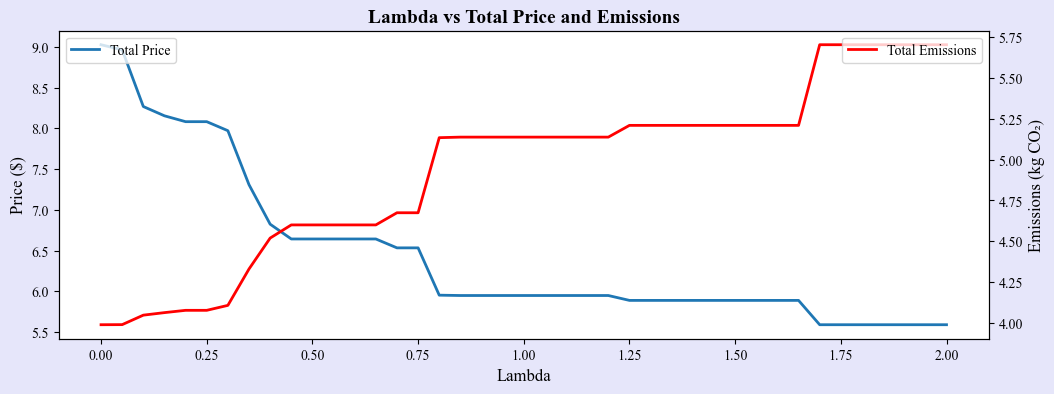

In [68]:
using PyPlot

PyPlot.matplotlib[:rc]("figure", facecolor="lavender")
PyPlot.matplotlib[:rc]("savefig", facecolor="lavender")
# PyPlot.matplotlib[:rc]("axes", facecolor="oldlace", edgecolor="black")
PyPlot.matplotlib[:rc]("font", family="Times New Roman") 

lambda = results_df[:, "Lambda"]
total_price = results_df[:, "Total_Price"]
total_emissions = results_df[:, "Total_Emissions"]

fig, ax1 = subplots(figsize=(12, 4))

# Plot Total Price on the first y-axis
ax1.plot(lambda, total_price, label="Total Price", linewidth=2)
ax1.set_xlabel("Lambda", fontsize=12)
ax1.set_ylabel("Price (\$)", fontsize=12)
ax1.tick_params(axis="y")
ax1.legend(loc="upper left")

# Plot Total Emissions on the second y-axis
ax2 = ax1.twinx()
ax2.plot(lambda, total_emissions, label="Total Emissions", color="red", linewidth=2)
ax2.set_ylabel("Emissions (kg CO₂)", fontsize=12)
ax2.tick_params(axis="y")
ax2.legend(loc="upper right")

# Set title and adjust layout
title("Lambda vs Total Price and Emissions", fontsize=14, weight="bold")

# Save the plot
PyPlot.savefig("Lambda_vs_Total_Price_and_Emissions_final.png", dpi=300, bbox_inches="tight", format="png")
PyPlot.show()


In [41]:
using Plots

lambda = results_df[:, "Lambda"]
total_price = results_df[:, "Total_Price"]
total_emissions = results_df[:, "Total_Emissions"]

# Create a plot with two y-axes
p = plot(lambda, total_price, label="Total Price", xlabel="Lambda", ylabel="Price (\$)", 
         legend=:topleft, linewidth=2, color=:blue, title="Lambda vs. Total Price and Emissions")

# Add Total Emissions with a secondary y-axis
plot!(twinx(), lambda, total_emissions, label="Total Emissions", color=:red, ylabel="Emissions (kg CO₂)", 
      legend=:topright, linewidth=2)

# Adjust plot size and layout
p = plot!(size=(1000, 500)) # Increase the size
#p = plot!(titlefont=font(12, "TIMES"), legendfontsize=8, xguidefontsize=10, yguidefontsize=10) # Adjust font sizes

# Save the plot
savefig(p, "Lambda_vs_Total_Price_and_Emissions.png")


"C:\\Users\\Rory\\OneDrive - Massachusetts Institute of Technology\\Documents\\Fall Semester\\Optimization Methods\\Project\\opt_proj\\Lambda_vs_Total_Price_and_Emissions.png"